In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

D:\anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Number of contours detected: 120


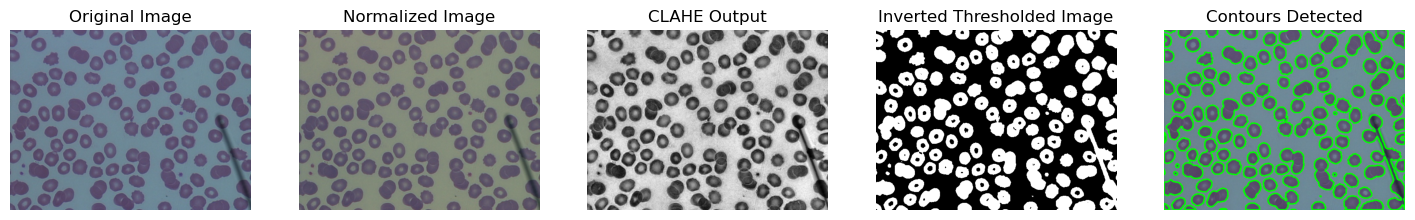

In [20]:
# Read the image
path="Dataset/4.jpg"
image = cv2.imread(path)

# Resize the image
image = cv2.resize(image, None, fx=0.9, fy=0.9)

# Compute average background values of the RGB channels
Ravg = np.mean(image[:,:,0])
Gavg = np.mean(image[:,:,1])
Bavg = np.mean(image[:,:,2])

# Normalize the image
normalized_image = np.zeros_like(image, dtype=np.float32)
normalized_image[:,:,0] = image[:,:,0] - (Ravg - np.mean(image))
normalized_image[:,:,1] = image[:,:,1] - (Gavg - np.mean(image))
normalized_image[:,:,2] = image[:,:,2] - (Bavg - np.mean(image))

# Clip values to stay within valid range [0, 255]
normalized_image = np.clip(normalized_image, 0, 255).astype(np.uint8)

# Convert the image to the green channel
green_channel = normalized_image[:,:,1]

# Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
clahe_output = clahe.apply(green_channel)

# Apply Otsu's thresholding
_, thresholded = cv2.threshold(clahe_output, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Invert the colors of the thresholded image
thresholded_inverted = cv2.bitwise_not(thresholded)

# Find contours
contours, _ = cv2.findContours(thresholded_inverted, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Visualize the data structure
print("Number of contours detected:", len(contours))

# Draw contours on the original image
image_copy = image.copy()
cv2.drawContours(image_copy, contours, -1, (0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

# Visualizing the results
plt.figure(figsize=(18, 6))

plt.subplot(1, 5, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(normalized_image)
plt.title('Normalized Image')
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(clahe_output, cmap='gray')
plt.title('CLAHE Output')
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(thresholded_inverted, cmap='gray')
plt.title('Inverted Thresholded Image')
plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
plt.title('Contours Detected')
plt.axis('off')

plt.show()


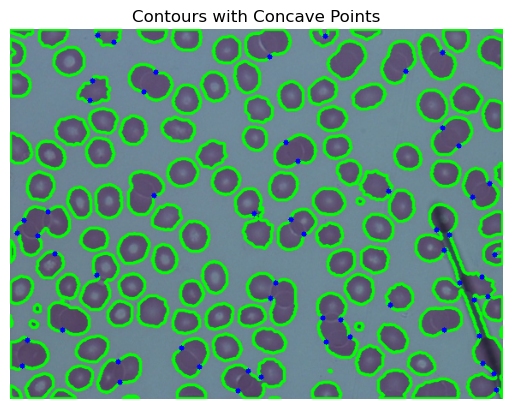

In [21]:
def find_concave_points(contour, k, min_distance):
    concave_points = []

    # Function to calculate distance between two points
    def distance(point1, point2):
        return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

    # Iterate through each point on the contour
    for i in range(len(contour)):
        xi, yi = contour[i][0]  # Get x, y coordinates of the current point

        # Calculate middle points of neighboring pairs
        middle_points = []
        for j in range(1, k + 1):
            # Calculate indices of left and right neighboring points
            left_index = (i - j) % len(contour)
            right_index = (i + j) % len(contour)

            # Get coordinates of left and right neighboring points
            xl, yl = contour[left_index][0]
            xr, yr = contour[right_index][0]

            # Calculate middle point as floats
            xm = (xl + xr) / 2.0  # Use float division
            ym = (yl + yr) / 2.0

            # Check if middle point is inside or outside the contour
            if cv2.pointPolygonTest(contour, (xm, ym), False) < 0:
                middle_points.append((xm, ym))  # Add middle point to the list

        # If all middle points are outside the contour, the point is a concave point
        if len(middle_points) == k:
            # If there are multiple concave points, filter based on minimum distance
            if len(concave_points) == 0 or all(distance((xi, yi), existing_point) > min_distance for existing_point in concave_points):
                concave_points.append((xi, yi))  # Add current point to the list of concave points

    return concave_points


k = 5  # Number of pairs of neighboring points to check
min_distance = 15  # Minimum distance threshold

# Iterate through each contour and find concave points
n_concavepoints = []
concavepoints = []
for contour in contours:
    concave_points = find_concave_points(contour, k, min_distance)
    concavepoints.append(np.array(concave_points))
    n_concavepoints.append(len(concave_points))


# Draw concave points on the contour_image
for points_array in concavepoints:
    for point in points_array:
        cv2.circle(image_copy, tuple(point), 3, (255, 0, 0), -1)  # Draw a blue circle at each concave point

# Visualization of the results
plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
plt.title('Contours with Concave Points')
plt.axis('off')
plt.show()


In [22]:
print("Number of contours detected:", len(contours))
num_blue_circles = sum(n_concavepoints)
print("Number of blue circles (concave points):", num_blue_circles)
num_overlap=[]
num_cell=[]
count=0
for x in n_concavepoints:
    if x>1:
        count=count+1
        num_overlap.append(x/2)
        num_cell.append(x/2+1)

rbc=len(contours)-count+sum(num_cell)
print("Number of RBC: ",rbc)

Number of contours detected: 120
Number of blue circles (concave points): 57
Number of RBC:  142.0
